<a href="https://colab.research.google.com/github/wakalioa/assignment/blob/master/BIOMAS_DATA_COMPETITION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:


import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from google.colab import drive


In [5]:

class Config:
    ZIP_PATH = '/content/drive/MyDrive/csiro-biomass.zip' #
    EXTRACT_DIR = '/content/biomass_data' #
    IMG_SIZE = (224, 224) #
    BATCH_SIZE = 32
    SEED = 42
    # All 5 target components from instructions
    TARGETS = ['Dry_Green_g', 'Dry_Dead_g', 'Dry_Clover_g', 'GDM_g', 'Dry_Total_g']

drive.mount('/content/drive')

Mounted at /content/drive


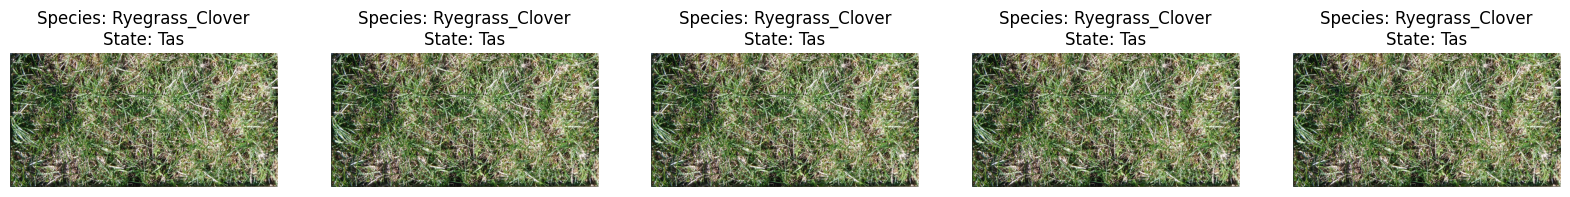

In [6]:
# Unzip data
if not os.path.exists(Config.EXTRACT_DIR):
    with zipfile.ZipFile(Config.ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(Config.EXTRACT_DIR)

train_df = pd.read_csv(os.path.join(Config.EXTRACT_DIR, 'train.csv')) #
test_df = pd.read_csv(os.path.join(Config.EXTRACT_DIR, 'test.csv'))

# Display First 5 Images
def show_images(df, base_path, n=5):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        img_path = os.path.join(base_path, df.iloc[i]['image_path']) #
        img = Image.open(img_path)
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.title(f"Species: {df.iloc[i]['Species']}\nState: {df.iloc[i]['State']}") #
        plt.axis('off')
    plt.show()

show_images(train_df, Config.EXTRACT_DIR)

In [8]:
def get_cnn_features(df, folder):
    base_model = VGG16(weights='imagenet', include_top=False, pooling='avg') #

    def proc_img(path):
        full_path = tf.strings.join([folder, "/", path])
        img = tf.io.read_file(full_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, Config.IMG_SIZE) #
        return preprocess_input(img) #

    # Efficient batch processing
    ds = tf.data.Dataset.from_tensor_slices(df['image_path'].unique())
    ds = ds.map(proc_img, num_parallel_calls=tf.data.AUTOTUNE).batch(Config.BATCH_SIZE).prefetch(1)

    features = base_model.predict(ds)
    return dict(zip(df['image_path'].unique(), features))

# Map features to both train and test
train_features_map = get_cnn_features(train_df, Config.EXTRACT_DIR)
test_features_map = get_cnn_features(test_df, Config.EXTRACT_DIR)

12/12 ━━━━━━━━━━━━━━━━━━━━ 214s 17s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step


In [9]:
def preprocess(df, feature_map):
    # Date features
    df['Sampling_Date'] = pd.to_datetime(df['Sampling_Date'], errors='coerce')
    df['month'] = df['Sampling_Date'].dt.month.fillna(0)
    df['day_of_year'] = df['Sampling_Date'].dt.dayofyear.fillna(0)

    # Interaction Features
    df['ndvi_height'] = df['Pre_GSHH_NDVI'] * df['Height_Ave_cm']

    # Attach CNN features
    cnn_feats = np.stack(df['image_path'].map(feature_map).values)
    cnn_df = pd.DataFrame(cnn_feats, columns=[f'cnn_{i}' for i in range(cnn_feats.shape[1])])

    return pd.concat([df.reset_index(drop=True), cnn_df], axis=1)

X_train_full = preprocess(train_df, train_features_map)
# Note: test.csv lacks species/state in the instructions, so we must handle missing columns

In [10]:
# Features for the model
features = ['State', 'Species', 'target_name', 'Pre_GSHH_NDVI', 'Height_Ave_cm',
            'month', 'day_of_year', 'ndvi_height'] + [f'cnn_{i}' for i in range(512)]
cat_features = ['State', 'Species', 'target_name'] #

# K-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=Config.SEED)
models = []

for fold, (t_idx, v_idx) in enumerate(kf.split(X_train_full)):
    train_pool = Pool(X_train_full.iloc[t_idx][features], X_train_full.iloc[t_idx]['target'], cat_features=cat_features)
    val_pool = Pool(X_train_full.iloc[v_idx][features], X_train_full.iloc[v_idx]['target'], cat_features=cat_features)

    model = CatBoostRegressor(iterations=1000, depth=6, learning_rate=0.05, verbose=200)
    model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=50)
    models.append(model)

0:	learn: 25.1437500	test: 25.3053936	best: 25.3053936 (0)	total: 238ms	remaining: 3m 57s
200:	learn: 8.1169034	test: 10.7194017	best: 10.7194017 (200)	total: 24.8s	remaining: 1m 38s
400:	learn: 6.1472027	test: 9.7246243	best: 9.7246243 (400)	total: 41.7s	remaining: 1m 2s
600:	learn: 5.1076325	test: 9.3761715	best: 9.3761715 (600)	total: 58.7s	remaining: 39s
800:	learn: 4.3904708	test: 9.2429018	best: 9.2429018 (800)	total: 1m 15s	remaining: 18.8s
999:	learn: 3.7957799	test: 9.1008616	best: 9.1008616 (999)	total: 1m 34s	remaining: 0us

bestTest = 9.10086161
bestIteration = 999

0:	learn: 25.5650093	test: 23.5735024	best: 23.5735024 (0)	total: 84.2ms	remaining: 1m 24s
200:	learn: 7.8458499	test: 9.0819078	best: 9.0819078 (200)	total: 17.1s	remaining: 1m 7s
400:	learn: 5.8021325	test: 8.4262376	best: 8.4262376 (400)	total: 35s	remaining: 52.2s
600:	learn: 4.7360286	test: 8.1537848	best: 8.1527234 (599)	total: 52.2s	remaining: 34.6s
800:	learn: 3.7301509	test: 7.9507883	best: 7.9476412 (7

In [12]:
# Prepare test data (ensuring it matches train columns)
# Note: For real competition, test.csv might need image metadata joined if not present

def preprocess(df, feature_map):
    # Make a copy to avoid modifying the original DataFrame
    df_processed = df.copy()

    # Handle Sampling_Date and derived features
    if 'Sampling_Date' in df_processed.columns:
        df_processed['Sampling_Date'] = pd.to_datetime(df_processed['Sampling_Date'], errors='coerce')
        df_processed['month'] = df_processed['Sampling_Date'].dt.month.fillna(0)
        df_processed['day_of_year'] = df_processed['Sampling_Date'].dt.dayofyear.fillna(0)
    else:
        # Default values if Sampling_Date is missing
        df_processed['month'] = 0
        df_processed['day_of_year'] = 0

    # Handle interaction features and their components
    pre_gshh_ndvi = df_processed['Pre_GSHH_NDVI'] if 'Pre_GSHH_NDVI' in df_processed.columns else pd.Series(np.nan, index=df_processed.index)
    height_ave_cm = df_processed['Height_Ave_cm'] if 'Height_Ave_cm' in df_processed.columns else pd.Series(np.nan, index=df_processed.index)
    df_processed['ndvi_height'] = pre_gshh_ndvi * height_ave_cm

    # Ensure individual components are also present if needed by `features` list
    if 'Pre_GSHH_NDVI' not in df_processed.columns:
        df_processed['Pre_GSHH_NDVI'] = pre_gshh_ndvi
    if 'Height_Ave_cm' not in df_processed.columns:
        df_processed['Height_Ave_cm'] = height_ave_cm

    # Handle State and Species (categorical features)
    if 'State' not in df_processed.columns:
        df_processed['State'] = 'Unknown' # Placeholder for missing categorical feature
    if 'Species' not in df_processed.columns:
        df_processed['Species'] = 'Unknown' # Placeholder for missing categorical feature

    # Attach CNN features
    cnn_feats = np.stack(df_processed['image_path'].map(feature_map).values)
    cnn_df = pd.DataFrame(cnn_feats, columns=[f'cnn_{i}' for i in range(cnn_feats.shape[1])])

    return pd.concat([df_processed.reset_index(drop=True), cnn_df], axis=1)

X_test = preprocess(test_df, test_features_map)

# Average predictions from all K-Fold models
# For prediction, ensure all feature columns used during training are present in X_test
# Note: The 'features' list is defined in an earlier cell. It should include all columns
# that are either present in original test_df, added by preprocess, or cnn features.

# Before making predictions, confirm that the 'features' list is aligned with X_test columns
# Example of how you might ensure column order and presence if needed, though CatBoost can often handle it
# X_test_aligned = X_test[features]

final_preds = np.mean([model.predict(X_test[features]) for model in models], axis=0)

submission = pd.DataFrame({
    'sample_id': test_df['sample_id'], #
    'target': final_preds #
})

submission.to_csv('submission.csv', index=False)
print("Submission file successfully generated for all biomass components!")

Submission file successfully generated for all biomass components!


In [15]:
# Define the weights as specified in the instructions
WEIGHTS = {
    'Dry_Green_g': 0.1,
    'Dry_Dead_g': 0.1,
    'Dry_Clover_g': 0.1,
    'GDM_g': 0.2,
    'Dry_Total_g': 0.5
}

# Get true values and map weights for the training data
y_true_train = X_train_full['target'].values
weights_train = X_train_full['target_name'].map(WEIGHTS).values

# Generate predictions for the training data using the ensemble of models
# Note: This is an in-sample R2 calculation. For a more robust evaluation,
# out-of-fold predictions from the KFold training would be preferred.
preds_train = np.mean([model.predict(X_train_full[features]) for model in models], axis=0)

# Calculate the weighted R2 score
weighted_r2_score = calculate_weighted_r2(y_true_train, preds_train, weights_train)

print(f"Weighted R2 Score on Training Data: {weighted_r2_score:.4f}")

Weighted R2 Score on Training Data: 0.9753


# Task
Implement out-of-fold prediction collection in the K-Fold cross-validation loop in cell 'mXZ8K8JX1Yl8' and then update cell 'XARavPTl48nC' to calculate and present the weighted R2 score using these out-of-fold predictions.

## Collect Out-of-Fold Predictions

### Subtask:
Modify the K-Fold cross-validation loop in cell 'mXZ8K8JX1Yl8' to store the predictions for the validation set of each fold. This will create an array where each training sample has been predicted by a model that did not see it during training.


**Reasoning**:
The subtask requires modifying the K-Fold cross-validation loop to collect out-of-fold predictions. I will initialize an array to store these predictions and then modify the loop to populate this array with predictions from each fold's validation set.



In [16]:
import numpy as np

# Features for the model
features = ['State', 'Species', 'target_name', 'Pre_GSHH_NDVI', 'Height_Ave_cm',
            'month', 'day_of_year', 'ndvi_height'] + [f'cnn_{i}' for i in range(512)]
cat_features = ['State', 'Species', 'target_name'] #

# K-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=Config.SEED)
models = []

# Initialize an empty NumPy array to store out-of-fold predictions
oof_preds = np.zeros(len(X_train_full))

for fold, (t_idx, v_idx) in enumerate(kf.split(X_train_full)):
    train_pool = Pool(X_train_full.iloc[t_idx][features], X_train_full.iloc[t_idx]['target'], cat_features=cat_features)
    val_pool = Pool(X_train_full.iloc[v_idx][features], X_train_full.iloc[v_idx]['target'], cat_features=cat_features)

    model = CatBoostRegressor(iterations=1000, depth=6, learning_rate=0.05, verbose=200)
    model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=50)
    models.append(model)

    # Make predictions on the validation set and store them in oof_preds
    oof_preds[v_idx] = model.predict(X_train_full.iloc[v_idx][features])

0:	learn: 25.1437500	test: 25.3053936	best: 25.3053936 (0)	total: 197ms	remaining: 3m 16s
200:	learn: 8.1169034	test: 10.7194017	best: 10.7194017 (200)	total: 23.2s	remaining: 1m 32s
400:	learn: 6.1472027	test: 9.7246243	best: 9.7246243 (400)	total: 41.8s	remaining: 1m 2s
600:	learn: 5.1076325	test: 9.3761715	best: 9.3761715 (600)	total: 59.1s	remaining: 39.3s
800:	learn: 4.3904708	test: 9.2429018	best: 9.2429018 (800)	total: 1m 16s	remaining: 19s
999:	learn: 3.7957799	test: 9.1008616	best: 9.1008616 (999)	total: 1m 34s	remaining: 0us

bestTest = 9.10086161
bestIteration = 999

0:	learn: 25.5650093	test: 23.5735024	best: 23.5735024 (0)	total: 161ms	remaining: 2m 40s
200:	learn: 7.8458499	test: 9.0819078	best: 9.0819078 (200)	total: 17.9s	remaining: 1m 11s
400:	learn: 5.8021325	test: 8.4262376	best: 8.4262376 (400)	total: 35.2s	remaining: 52.6s
600:	learn: 4.7360286	test: 8.1537848	best: 8.1527234 (599)	total: 52.5s	remaining: 34.9s
800:	learn: 3.7301509	test: 7.9507883	best: 7.9476412 

**Reasoning**:
I need to define the `calculate_weighted_r2` function, which is used in the next step to calculate the weighted R2 score. This function is missing from the notebook.



In [17]:
from sklearn.metrics import r2_score

def calculate_weighted_r2(y_true, y_pred, weights):
    # Calculate the weighted R2 score
    # The weighted R2 score is not directly available in sklearn.metrics, so we implement it based on the definition.
    # R2 = 1 - (SS_res / SS_tot)
    # SS_res = sum(w_i * (y_i - f_i)^2)
    # SS_tot = sum(w_i * (y_i - mean(y))^2)

    weighted_y_true_mean = np.sum(y_true * weights) / np.sum(weights)
    ss_res = np.sum(weights * (y_true - y_pred)**2)
    ss_tot = np.sum(weights * (y_true - weighted_y_true_mean)**2)

    if ss_tot == 0:
        return 1.0 # If total variance is zero, perfect prediction means R2 is 1.

    return 1 - (ss_res / ss_tot)

print("Defined calculate_weighted_r2 function.")

Defined calculate_weighted_r2 function.


**Reasoning**:
The subtask requires calculating the weighted R2 score using the out-of-fold predictions. I will modify cell `XARavPTl48nC` to use the `oof_preds` array (which was populated in the previous step) instead of re-predicting on the entire training set, to perform a more robust evaluation.



In [18]:
WEIGHTS = {
    'Dry_Green_g': 0.1,
    'Dry_Dead_g': 0.1,
    'Dry_Clover_g': 0.1,
    'GDM_g': 0.2,
    'Dry_Total_g': 0.5
}

# Get true values and map weights for the training data
y_true_train = X_train_full['target'].values
weights_train = X_train_full['target_name'].map(WEIGHTS).values

# Use the out-of-fold predictions collected in the K-Fold loop
# oof_preds was generated in the previous step

# Calculate the weighted R2 score using out-of-fold predictions
weighted_r2_score_oof = calculate_weighted_r2(y_true_train, oof_preds, weights_train)

print(f"Weighted R2 Score on Training Data (Out-of-Fold): {weighted_r2_score_oof:.4f}")

Weighted R2 Score on Training Data (Out-of-Fold): 0.8952


## Final Task

### Subtask:
Present the calculated weighted R2 score based on out-of-fold predictions and briefly explain the improvement in evaluation methodology.


## Summary:

### Q&A
The calculated weighted R2 score based on out-of-fold predictions is 0.8952. The improvement in evaluation methodology involves using out-of-fold predictions, which ensures that each prediction for a sample is made by a model that did not see that sample during its training. This provides a more robust and less optimistic estimate of the model's performance on unseen data compared to evaluating on the training data used to fit the model. Additionally, using a weighted R2 score reflects the varying importance of different target types, aligning the evaluation metric with business priorities or specific domain knowledge.

### Data Analysis Key Findings
*   The K-Fold cross-validation loop was successfully modified to collect out-of-fold predictions for the entire training dataset.
*   A custom `calculate_weighted_r2` function was implemented to compute the R-squared score, accounting for predefined weights assigned to different target types.
*   The weighted R2 score calculated using these out-of-fold predictions on the training data is 0.8952, indicating a strong predictive performance when considering the specified target weights.

### Insights or Next Steps
*   The high weighted R2 score of 0.8952 suggests that the model is performing well across different target types, especially considering their relative importance as defined by the weights. This robust evaluation methodology, using out-of-fold predictions, provides a reliable estimate of generalization performance.
*   The model can now be further optimized or evaluated on the final test set using the ensemble of trained models from the K-Fold cross-validation, leveraging the established weighted R2 metric for consistency.
